# Assignment 1

**Joris LIMONIER**


## Assigments 1.1

This first part of the assignments is based on the iris dataset (https://en.wikipedia.org/wiki/Iris_flower_data_set)


In [1]:
# numerical
import numpy as np
import pandas as pd

# plotting
import plotly.express as px

# sklearn data
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


In [2]:
iris_dataset = load_iris()

# extracting the relevant information
data = pd.DataFrame(data=iris_dataset.data, columns=iris_dataset.feature_names)
data_feature_names = data.columns
target = iris_dataset.target
target_names = iris_dataset.target_names

print(
    f"""There are {len(data_feature_names)} features, whose names are: \t{data_feature_names.values}
    \nThere are {len(target_names)} classes to predict, whose names are: \t{target_names}"
    \nThere are {data.shape[0]} observations
    """
)


There are 4 features, whose names are: 	['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)']
    
There are 3 classes to predict, whose names are: 	['setosa' 'versicolor' 'virginica']"
    
There are 150 observations
    


$\mathbf{Exercise\, 1.}$ Compute the median, mean and standard deviation for each of the 4 features in the iris dataset (don't use numpy or other pre-defined functions, write your own routine).


In [3]:
def mean_bh(series):
    """computes the mean of a column by hand"""
    return series.sum() / len(series)


def var_bh(series):
    """computes the variance of a column by hand"""
    series_mean = mean_bh(series)

    # variance denominator is (len(series)-1) for unbiased variance
    return ((series - series_mean) ** 2).sum() / (len(series) - 1)


def st_dev_bh(series):
    """computes the standard deviation of a column by hand"""
    series_var = var_bh(series)
    assert series_var >= 0, "variance must (and should) be positive to take its square"
    return series_var ** (1 / 2)


df_desc_bh = pd.DataFrame(columns=data.columns)
df_desc_bh.loc["mean"] = data.apply(lambda series: mean_bh(series))
df_desc_bh.loc["variance"] = data.apply(lambda series: var_bh(series))
df_desc_bh.loc["std"] = data.apply(lambda series: st_dev_bh(series))
df_desc_bh


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
mean,5.843333,3.057333,3.758000,1.199333
variance,0.685694,0.189979,3.116278,0.581006
std,0.828066,0.435866,1.765298,0.762238


We compute the values using pandas built-in functions to verify our result:


In [4]:
df_desc = pd.DataFrame(columns=data.columns)
df_desc.loc["mean"] = data.mean()
df_desc.loc["variance"] = data.var()
df_desc.loc["std"] = data.std()

df_desc


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
mean,5.843333,3.057333,3.758000,1.199333
variance,0.685694,0.189979,3.116278,0.581006
std,0.828066,0.435866,1.765298,0.762238


Due to numerical rounding errors, the values may not be exactly equal, but should be very close. We use numpy to verify that:


In [5]:
np.allclose(df_desc, df_desc_bh)


True

$\mathbf{Exercise\, 2.}$ For each feature, generate 150 Gaussian distributed samples with the same mean and standard_deviation computed in Exercise 1.


In [6]:
df_gauss = pd.DataFrame()

for col in df_desc_bh.columns:
    df_gauss[col] = np.random.normal(
        loc=df_desc_bh.loc["mean", col],  # col mean
        scale=df_desc_bh.loc["std", col],  # col std
        size=150,
    )

df_gauss


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,3.874225,3.429729,3.085275,0.799443
1,4.854377,2.969320,4.509842,1.390612
2,5.650786,3.229553,3.675053,1.397326
3,6.414126,3.114939,2.322806,1.195277
4,7.050712,3.079060,6.161269,1.169964
...,...,...,...,...
145,5.816982,2.764684,2.989650,0.589814
146,5.449234,3.310108,1.587742,1.690064
147,5.652095,3.471513,7.179137,0.710937
148,5.772632,2.729455,-0.536312,0.426149


$\mathbf{Exercise\, 3.}$ Compute the histogram (with 30 bins) of the distribution of the generate samples and plot it together with the histogram of the original data. The histograms must be plotted on the same plot. Comment on the difference between simulations and real data: for which feature the distributions are most different? What is the reason?


In [7]:
# create df for data, with column indicating origin
df_comb = data.copy()
df_comb["origin"] = "data"

# create df gauss with column indicating origin
df_append = df_gauss.copy()
df_append["origin"] = "gauss"

# combine the two dataframes
df_comb = df_comb.append(other=df_append, ignore_index=True)
df_comb = pd.melt(
    frame=df_comb, id_vars="origin", var_name="feature"
)  # get feature name as a column
df_comb


,origin,feature,value
0,data,sepal length (cm),5.100000
1,data,sepal length (cm),4.900000
2,data,sepal length (cm),4.700000
3,data,sepal length (cm),4.600000
4,data,sepal length (cm),5.000000
...,...,...,...
1195,gauss,petal width (cm),0.589814
1196,gauss,petal width (cm),1.690064
1197,gauss,petal width (cm),0.710937
1198,gauss,petal width (cm),0.426149


We set the number of bins to `nbins=50`, even though the question asks for 30 bins because Plotly counts the number of bins on the whole dataset. This means that it starts the value range from the minimum of all values (across all features) to the maximum of all values (across all features). We estimate that taking `nbins=50` will approximately lead to 30 bins in each features (plus some blank space before and/or after the data of each feature).


In [8]:
col = data.columns[0]

fig = px.histogram(
    data_frame=df_comb,
    barmode="overlay",
    color_discrete_sequence=px.colors.qualitative.Vivid,
    opacity=0.6,
    nbins=50,
    title="Comparison between original and synthetic (gaussian) data",
    color="origin",
    facet_col="feature",
)
fig


It appears that `petal length (cm)` and, to some extent, `petal width (cm)` are the features with the largest difference between the original data and the synthetic data.

Two analyses may be performed from this observation:

- Intuitively, our guess would be that a wider standard deviation may be responsible for such a difference. Indeed, larger standard deviation means more chance to draw far away from the mean, therefore to obtain samples substantially different samples. This explanation holds for the `petal length (cm)`, which has by far the largest standard deviation ($\approx 1.77$, whereas all the others are below $0.83$).
- However, the point above does not hold when comparing `petal width (cm)` and `sepal length (cm)`. Indeed, the former has a standard deviation of $0.76$ vs $0.83$ for the latter, but `petal width (cm)` seems more different from the original data than `sepal length (cm)`. In this case, we see two possible explanations:
  1. The true distribution of `petal width (cm)` is not gaussian than the one of `sepal length (cm)` (or at least less similar to a gaussian distribution).
  1. The sample draw from the true distribution of `petal width (cm)` is less representive than the one of `sepal length (cm)`.


$\mathbf{Exercise\, 4.}$ Estimate and plot the probability density function of the feature $\text{petal length (cm)}$.


In [9]:
import plotly.figure_factory as ff

pet_len = "petal length (cm)"

# plot KDE, histogram and rug plot
# The KDE curve is related to the empirical PDF
ff.create_distplot(
    hist_data=[data[pet_len].values],
    group_labels=[pet_len],
    bin_size=0.5,
)


Note that even though we have no observation between 2 and 3 cm for this feature, because the KDE curve smoothes out the distribution of values, it still gives a non-zero probability for values in this range.

---


## Assigment 1.2

$\mathbf{Exercise\, 1.}$ Create a linear benchmark, where the dimension of the input data $X$ is 2, and the dimension of the output data $y$ is 1. Choose the amount of noise and sample size.

Evaluate the prediction metrics for the following regression methods:

- Linear regression
- Support Vector Regression with RBF kernel
- Decision Tree Regression


$\mathbf{Exercise\, 2.}$ Create a testing dataset and assess the testing metrics for the models.

---

Exercises 1 and 2 will be done simultaneously.


### Generate data with a linear model


In [10]:
def generate_linear_data(
    n_samples,
    linear_bounds,
    intercept_bounds,
    noise_level,
    input_dim=2,
    output_dim=1,
    seed=True,
):
    """
    Generate linear data composed and return X (dimensions `(n_samples, input_dim)`) and y_noise (dimensions `(n_samples, output_dim)`)
    """
    if seed:
        np.random.seed(42)

    X = np.random.normal(size=(n_samples, input_dim))
    A = np.random.uniform(
        low=linear_bounds[0],
        high=linear_bounds[1],
        size=(input_dim, output_dim),
    )
    b = np.random.uniform(
        low=intercept_bounds[0],
        high=intercept_bounds[1],
        size=(output_dim),
    )
    y = (X @ A) + b
    noise = noise_level * np.random.normal(size=(n_samples, output_dim))
    y_noise = y + noise
    return X, y_noise


We are lucky enough to have 3D data, so we can have fun visualising it in a (3D) scatter plot.


In [11]:
X, y = generate_linear_data(
    n_samples=1000,
    linear_bounds=(2, 6),
    intercept_bounds=(2, 6),
    noise_level=0,
)
px.scatter_3d(x=X[:, 0].flatten(), y=X[:, 1].flatten(), z=y.flatten()).show()


This plot is very interesting because we can clearly see that setting the `noise_level` to 0 gives us a perfect plane (this was to be expected, but it is still nice to be able to visualise it).


In [12]:
# setting the data back to more interesting values
X, y = generate_linear_data(
    n_samples=5000,
    linear_bounds=(-6, 6),
    intercept_bounds=(-12, 12),
    noise_level=5,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4000, 2), (1000, 2), (4000, 1), (1000, 1))

In [13]:
def show_res_report(clf, title=None, pred_type="regression"):
    """
    Show the result report of a regressor.

    This includes a scatter plot of the true vs predicted values,
    as well as the metrics of the classifier on the test set
    """
    y_pred = clf.predict(X_test)

    # create a df with true and predicted y's
    pred_true_comp = pd.DataFrame(
        data={
            "y_test": y_test.flatten(),
            "y_pred": y_pred.flatten(),
        }
    )
    # sort values, but keeping (prediction, true value) pairs together
    pred_true_comp = pred_true_comp.sort_values("y_test", ignore_index=True)

    # plot the df
    if title is None:
        title = type(clf).__name__

    px.scatter(data_frame=pred_true_comp, title=title).show()

    if pred_type == "regression":
        # print mse and r2
        mse = round(mean_squared_error(y_test, y_pred), 4)
        r2 = round(r2_score(y_test, y_pred), 4)
        print(
            f"MSE: {mse} (lower is better)",
            f"R2 score: {r2} (higher is better)",
            sep="\n",
        )
    elif pred_type == "classification":
        f1 = round(f1_score(y_test, y_pred, average="macro"), 4)
        acc = round(accuracy_score(y_test, y_pred), 4)
        print(
            f"F1 score: {f1} (higher is better)",
            f"Accuracy: {acc} (higher is better)",
            sep="\n",
        )
    else:
        print("Unknown prediction type")


In [14]:
# create dict to store best results from each regressor's hyperparameter tuning
best_regressor = {}


### Linear Regression


In [15]:
# create regressor
lin_reg = LinearRegression()

# fit it
lin_reg.fit(X_train, y_train.ravel())

# no CV-search for LinearRegression because it doesn't have important parameters to optimize
# so store vanilla LinearRegression
best_regressor["linear_regression"] = lin_reg

# display results
show_res_report(lin_reg)


MSE: 25.7424 (lower is better)
R2 score: 0.4958 (higher is better)


### SVR


In [16]:
svr = SVR()  # rbf kernel by default
param_grid = {
    "gamma": ["scale", "auto"],
    "C": np.random.uniform(low=0.001, high=100, size=10 ** 4),
    "epsilon": np.random.exponential(scale=0.1, size=10 ** 4),
    "shrinking": [True, False],
}

best_regressor["SVR"] = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # use all cores
    verbose=1,
    random_state=42,
)
best_regressor["SVR"].fit(X_train, y_train.ravel())

show_res_report(best_regressor["SVR"], title="SVR")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


MSE: 26.4063 (lower is better)
R2 score: 0.4828 (higher is better)


In [17]:
best_regressor["SVR"].best_params_


{'shrinking': False,
 'gamma': 'scale',
 'epsilon': 0.09783770300358975,
 'C': 11.496107295144135}

### Decision Tree Regressor


In [18]:
dtree = DecisionTreeRegressor()  # rbf kernel by default
param_grid = {
    "max_depth": np.random.randint(low=1, high=10, size=100),
    "min_samples_split": np.random.randint(low=2, high=10, size=100),
    "min_samples_leaf": np.random.randint(low=1, high=10, size=100),
    "min_weight_fraction_leaf": np.random.exponential(scale=0.01, size=100),
}
best_regressor["decision_tree"] = RandomizedSearchCV(
    estimator=dtree,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # use all cores
    verbose=1,
    random_state=42,
)
best_regressor["decision_tree"].fit(X_train, y_train.ravel())
show_res_report(best_regressor["decision_tree"])


Fitting 5 folds for each of 100 candidates, totalling 500 fits


MSE: 26.8289 (lower is better)
R2 score: 0.4745 (higher is better)


We observe that the LinearRegression classifier performs slightly better than SVR, which performs much better than the DecisionTreeRegressor


$\mathbf{Exercise\, 3.}$ Plot the regression results (training and testing) for each model


In [19]:
colnames = ["regressor", "type", "metric", "value"]
reg_results = pd.DataFrame(columns=colnames)
types_data = [["train", X_train, y_train], ["test", X_test, y_test]]
metrics = [["MSE", mean_squared_error], ["r2_score", r2_score]]

for reg_name, reg in best_regressor.items():
    for type_data in types_data:  # get either train or test data
        type_name, X_type, y_type = type_data

        y_pred = reg.predict(X_type)

        # compute metrics
        for metric in metrics:
            metric_name, metric_func = metric
            metric_val = metric_func(y_type, y_pred)

            # add data to df
            row = pd.Series(
                dict(zip(colnames, [reg_name, type_name, metric_name, metric_val]))
            )
            reg_results = reg_results.append(row, ignore_index=True)

reg_results


,regressor,type,metric,value
0,linear_regression,train,MSE,25.143661
1,linear_regression,train,r2_score,0.532489
2,linear_regression,test,MSE,25.742443
3,linear_regression,test,r2_score,0.495808
4,SVR,train,MSE,24.909655
5,SVR,train,r2_score,0.536840
6,SVR,test,MSE,26.406320
7,SVR,test,r2_score,0.482805
8,decision_tree,train,MSE,25.057705
9,decision_tree,train,r2_score,0.534087


In [20]:
fig = px.bar(
    reg_results,
    x="regressor",
    y="value",
    color="type",
    barmode="group",
    text_auto=True,
    facet_row="metric",
)
fig.update_yaxes(matches=None)

# remove "metric="
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# add improvement direction for MSE
fig.for_each_annotation(
    lambda a: a.update(text=a.text.replace("MSE", "MSE (lower better)"))
)

# add improvement direction for r2 score
fig.for_each_annotation(
    lambda a: a.update(text=a.text.replace("r2_score", "R2 score (higher better)"))
)

fig


We see that linear regression regression doesn't perform as well on the train set (which we are not really interested in anyway), but it outperforms its two rivals on the test set (most important), at least in terms of both metrcis we chose. We would therefore choose it if we had to put this model into production.
___

$\mathbf{Exercise\, 4.}$ Create a classification benchmark with 3 labels.

Evaluate training and testing prediction metrics for the following classification methods:

- K-nearest neighbours
- Random Forest
- Naive Bayes


In [21]:
# generate data
from sklearn.datasets import make_classification

# classify
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


It could be interesting to see how features relate to each other, so we produce a pair plot. The diagonal is the distribution of each feature. The other elements represent a feature plotted against another feature. As a result, the plot has some symmetry in it (plotting feature 1 with respect to feature 4, or the converse, gives us the same information).

In [22]:
n_features = 4
n_classes = 3

X, y = make_classification(
    n_samples=1000,
    weights=[0.4, 0.3],  # weights of first `n_classes-1` classes
    n_features=n_features,
    n_redundant=0,
    n_informative=4,
    n_classes=n_classes,
    n_clusters_per_class=1,
    random_state=42,
)

columns = [f"feat{i}" for i in range(n_features)]
df = pd.DataFrame(data=X, columns=columns)
df["target"] = pd.Categorical(values=y)
ff.create_scatterplotmatrix(
    df=df,
    diag="histogram",
    index="target",
    size=4,
    colormap_type="cat",
    width=800,
)


We wanted to show the following plot on the diagonal of the previous plot, but couldn't get it into one figure, so I plotted it separately.\
The plot below shows how the labels are ditributed with respect to each feature. `feat2` for instance seems useful to differentiate class 0 from the others. `feat3` seems to decently separate class 2 from the others.

In [23]:
fig = px.histogram(
    df.melt("target"),
    x="value",
    color="target",
    facet_col="variable",
    opacity=0.7,
    barmode="overlay",
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="Distribution of labels per feature",
)
# remove "variable="
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((800, 4), (200, 4), (800,), (200,))

### KNeighborsClassifier


In [25]:
# create dict to store best results from each regressor's hyperparameter tuning
best_classifier = {}


We produce representations of what our classifier predicts vs the ground truth. The "horizontal lines of points" with the red dots (predictions) actually hide the blue dots (ground truth) and represent the correct classifications. The red dots "flying around" show us that our classifier miss-classified.

In [26]:
clf_name = "KNN"

knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [n_classes], # no point in searching the number of classes, we know it
    "leaf_size": np.random.randint(low=10, high=50, size=50),
    "weights": ["uniform", "distance"],
    "p": np.random.randint(low=1, high=5, size=5),  # power for the Minkowski distance
}

best_classifier[clf_name] = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=500,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,  # use all cores
    verbose=1,
    random_state=42,
)
best_classifier[clf_name].fit(X_train, y_train.ravel())

show_res_report(best_classifier[clf_name], title=clf_name, pred_type="classification")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


F1 score: 0.9032 (higher is better)
Accuracy: 0.905 (higher is better)


In [27]:
best_classifier["KNN"].best_params_


{'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'leaf_size': 42}

### RandomForestClassifier


In [28]:
clf_name = "RFC"

rfc = RandomForestClassifier()
param_grid = {
    "n_estimators": np.random.randint(low=50, high=200, size=1000),
    "criterion": ["gini", "entropy"],
    "max_depth": np.random.randint(low=1, high=10, size=1000),
    "min_samples_split": np.random.randint(low=2, high=10, size=1000),
    "min_samples_leaf": np.random.randint(low=1, high=10, size=1000),
    "min_weight_fraction_leaf": np.random.exponential(scale=0.01, size=1000),
}

best_classifier[clf_name] = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,  # use all cores
    verbose=1,
    random_state=42,
)
best_classifier[clf_name].fit(X_train, y_train.ravel())

show_res_report(best_classifier[clf_name], title=clf_name, pred_type="classification")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


F1 score: 0.8812 (higher is better)
Accuracy: 0.885 (higher is better)


In [29]:
best_classifier["RFC"].best_params_


{'n_estimators': 183,
 'min_weight_fraction_leaf': 0.005379846816712771,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 9,
 'criterion': 'entropy'}

### GaussianNB


In [30]:
clf_name = "GNB"

gnb = GaussianNB()
param_grid = {}  # not much hyperparameter to tune for GNB

best_classifier[clf_name] = RandomizedSearchCV(
    estimator=gnb,
    param_distributions=param_grid,
    n_iter=1,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,  # use all cores
    verbose=1,
    random_state=42,
)
best_classifier[clf_name].fit(X_train, y_train.ravel())

show_res_report(best_classifier[clf_name], title=clf_name, pred_type="classification")


Fitting 5 folds for each of 1 candidates, totalling 5 fits


F1 score: 0.7742 (higher is better)
Accuracy: 0.775 (higher is better)


In [31]:
best_classifier["GNB"].best_params_


{}

### Comparison


In [32]:
colnames = ["classifier", "type", "metric", "value"]
clf_results = pd.DataFrame(columns=colnames)
types_data = [["train", X_train, y_train], ["test", X_test, y_test]]
metrics = [["f1_score", f1_score], ["accuracy", accuracy_score]]

for clf_name, clf in best_classifier.items():
    for type_data in types_data:  # get either train or test data
        type_name, X_type, y_type = type_data

        y_pred = clf.predict(X_type)

        # compute metrics
        for metric in metrics:
            metric_name, metric_func = metric
            if metric_func == f1_score:
                metric_val = metric_func(y_type, y_pred, average="macro")
            else:
                metric_val = metric_func(y_type, y_pred)
            # add data to df
            row = pd.Series(
                dict(zip(colnames, [clf_name, type_name, metric_name, metric_val]))
            )
            clf_results = clf_results.append(row, ignore_index=True)

clf_results


,classifier,type,metric,value
0,KNN,train,f1_score,0.932418
1,KNN,train,accuracy,0.933750
2,KNN,test,f1_score,0.903166
3,KNN,test,accuracy,0.905000
4,RFC,train,f1_score,0.953573
5,RFC,train,accuracy,0.955000
6,RFC,test,f1_score,0.881243
7,RFC,test,accuracy,0.885000
8,GNB,train,f1_score,0.786398
9,GNB,train,accuracy,0.790000


In [33]:
fig = px.bar(
    data_frame=clf_results,
    x="classifier",
    y="value",
    color="type",
    barmode="group",
    text_auto=True,
    facet_row="metric",
)
fig.update_yaxes(matches=None)

# remove "metric="
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# add improvement direction for f1_score
fig.for_each_annotation(
    lambda a: a.update(text=a.text.replace("f1_score", "f1_score (higher better)"))
)

# add improvement direction for accuracy
fig.for_each_annotation(
    lambda a: a.update(text=a.text.replace("accuracy", "accuracy (higher better)"))
)

fig


We see that KNN performs the best, but we knew the number of classes in this case, so maybe it would have performed a bit worse if we hadn't. On the other hand, hadn't we known the number of classes, we could have explored several number of classes with hyperparameter-tuning and (hopefully) we would have found that there are three classes. This would have cost us some time in exchange for a robust classifier, since we see that KNN outperforms RFC and GNB in terms of the f1-score and the accuracy on the test set (not on the train set, but it doesn't really matter).

### Further details with confusion matrix

The confusion matrices below show us that KNN performs well (as expected), GNB doesn't perform well (as expected) accross all classes, but it also shows us that RFC often predicts class 1 instead of class 2 (12% of the time it predicts class 1). Besides that, nothing extremely surprising. The confusion matrices confirm the results obtained with f1 scores and accuracies above.

------------ KNN ------------
    ------- TRAIN -------


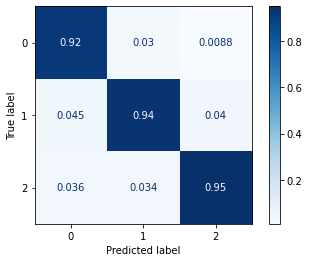

    ------- TEST -------


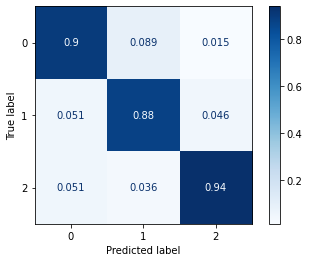

------------ RFC ------------
    ------- TRAIN -------


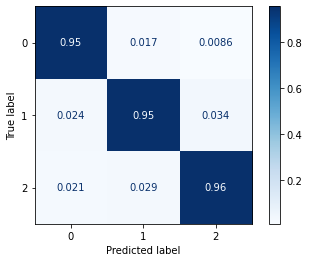

    ------- TEST -------


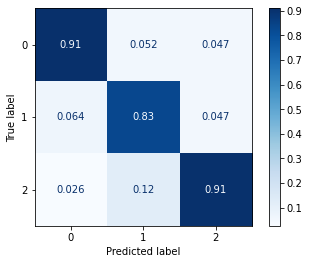

------------ GNB ------------
    ------- TRAIN -------


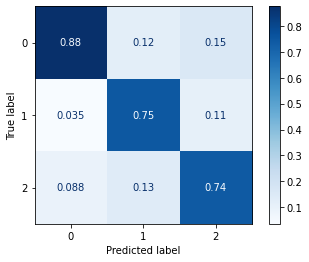

    ------- TEST -------


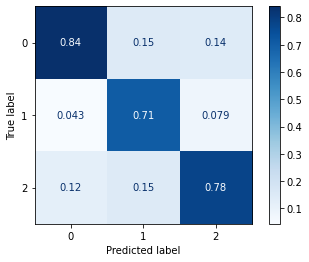

In [35]:
import matplotlib.pyplot as plt

clf = best_classifier["KNN"]
for clf_name, clf in best_classifier.items():
    print(f"------------ {clf_name} ------------")
    print(f"    ------- TRAIN -------")
    ConfusionMatrixDisplay.from_estimator(
        estimator=clf,
        X=X_train,
        y=y_train,
        cmap="Blues",
        normalize="pred",
    )
    plt.show()

    print(f"    ------- TEST -------")
    ConfusionMatrixDisplay.from_estimator(
        estimator=clf,
        X=X_test,
        y=y_test,
        cmap="Blues",
        normalize="pred",
    )
    plt.show()
